# Predicting Insurance Cost

- Author: [Brendan Reed](https://github.com/reedbc1)
- Repository: [ml_regression_brendan](https://github.com/reedbc1/ml_regression_brendan)

## Introduction

TODO: Remove this and customize your intro: Introduce the purpose of your project and provide background information on data sources, etc. 
The purpose of this notebook is to introduce notebooks for analytics. 

## Imports

In [178]:
from matplotlib.axes import Axes
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import pandas as pd
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


## Section 1. Import and Inspect the Data


### 1.1 Load the dataset and display the first 10 rows.

In [179]:
df = pd.read_csv(r"C:\Repos\ml_regression_brendan\data\insurance.csv")
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 1.2 Check for missing values and display summary statistics.

In [180]:
print(df.isnull().sum())
df.describe(include='all')

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


### Reflection 1: 
Observations:  
- There are no missing values
- The dataset has three categorical variables (sex, smoker, region)
- The remaining variables are numerical (age, bmi, children, charges)
- <b>charges</b> has at least one outlier (max: 63770.43)

Potential Issues:
- The <b>charges</b> outlier could present problems with training a regression model. A transformation could be worth exploring.

## Section 2. Data Exploration and Preparation



### 2.1 Explore data patterns and distributions

In [181]:
# Create histograms, boxplots, and count plots for categorical variables (as applicable).
# Identify patterns, outliers, and anomalies in feature distributions.
# Check for class imbalance in the target variable (as applicable).

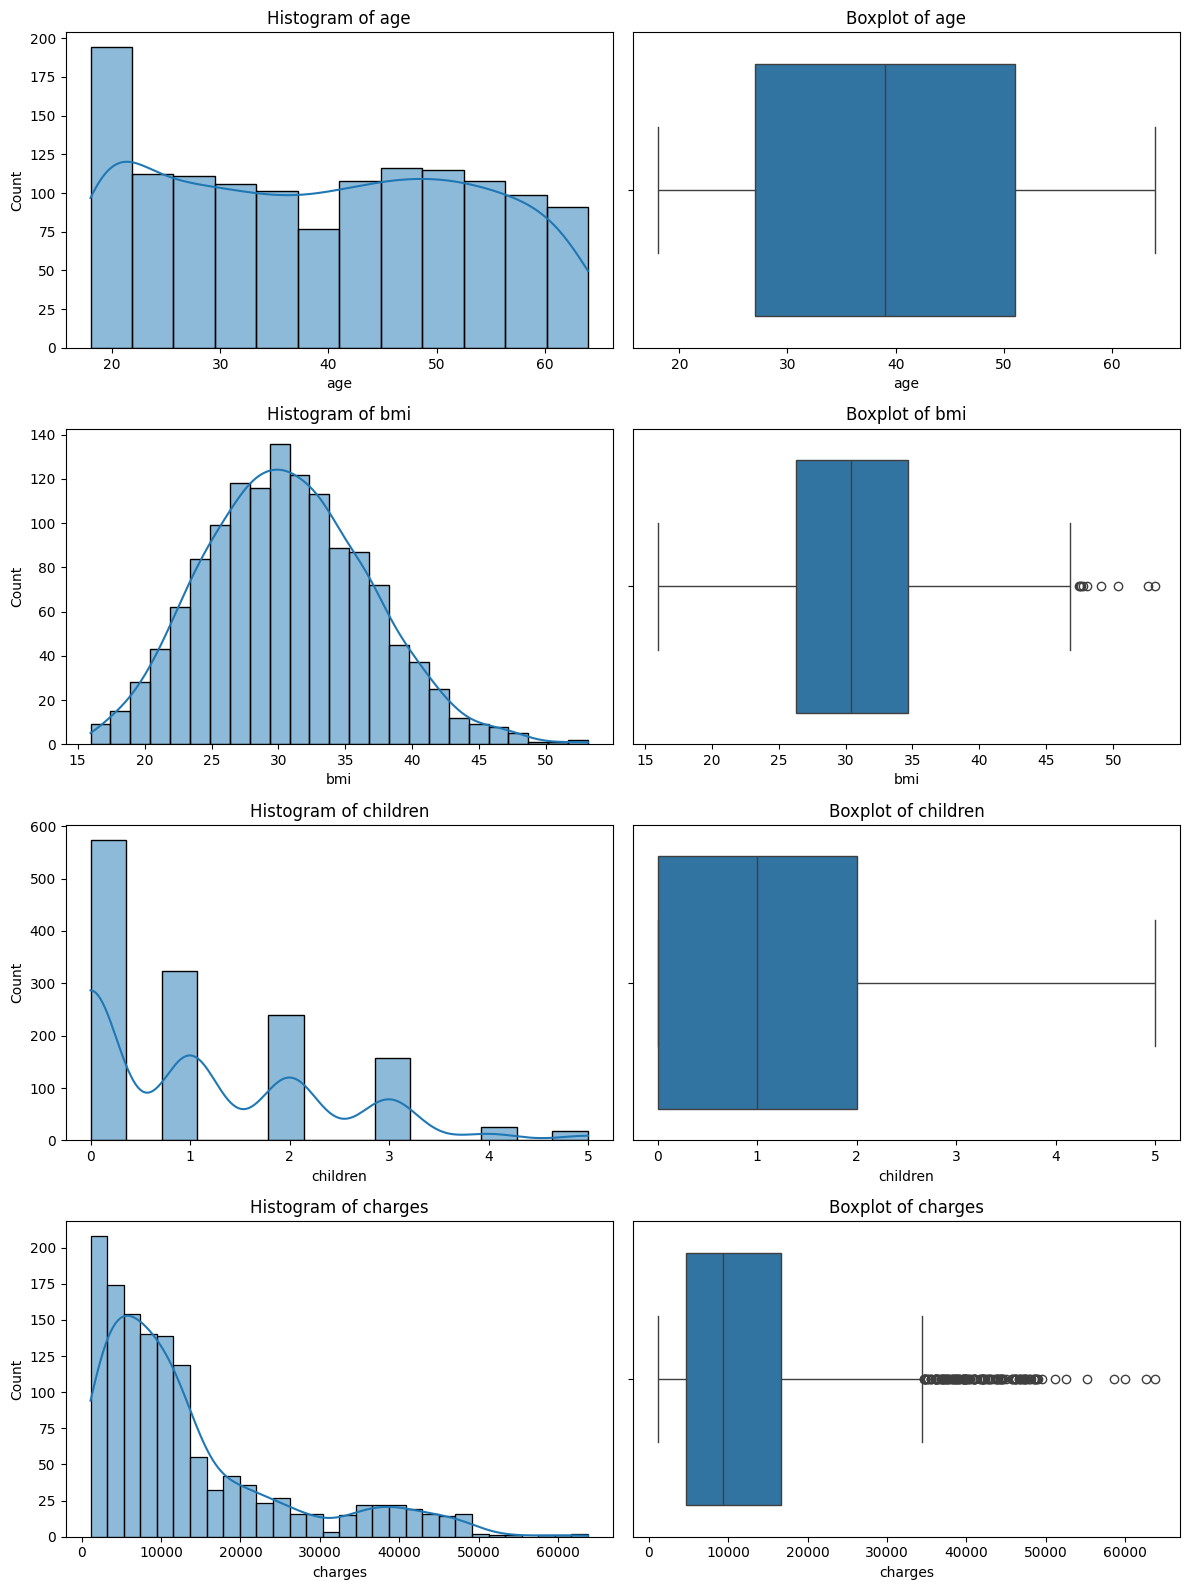

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(12, 4 * len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i,0])
    axes[i,0].set_title(f"Histogram of {col}")
    
    sns.boxplot(x=df[col], ax=axes[i,1])
    axes[i,1].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


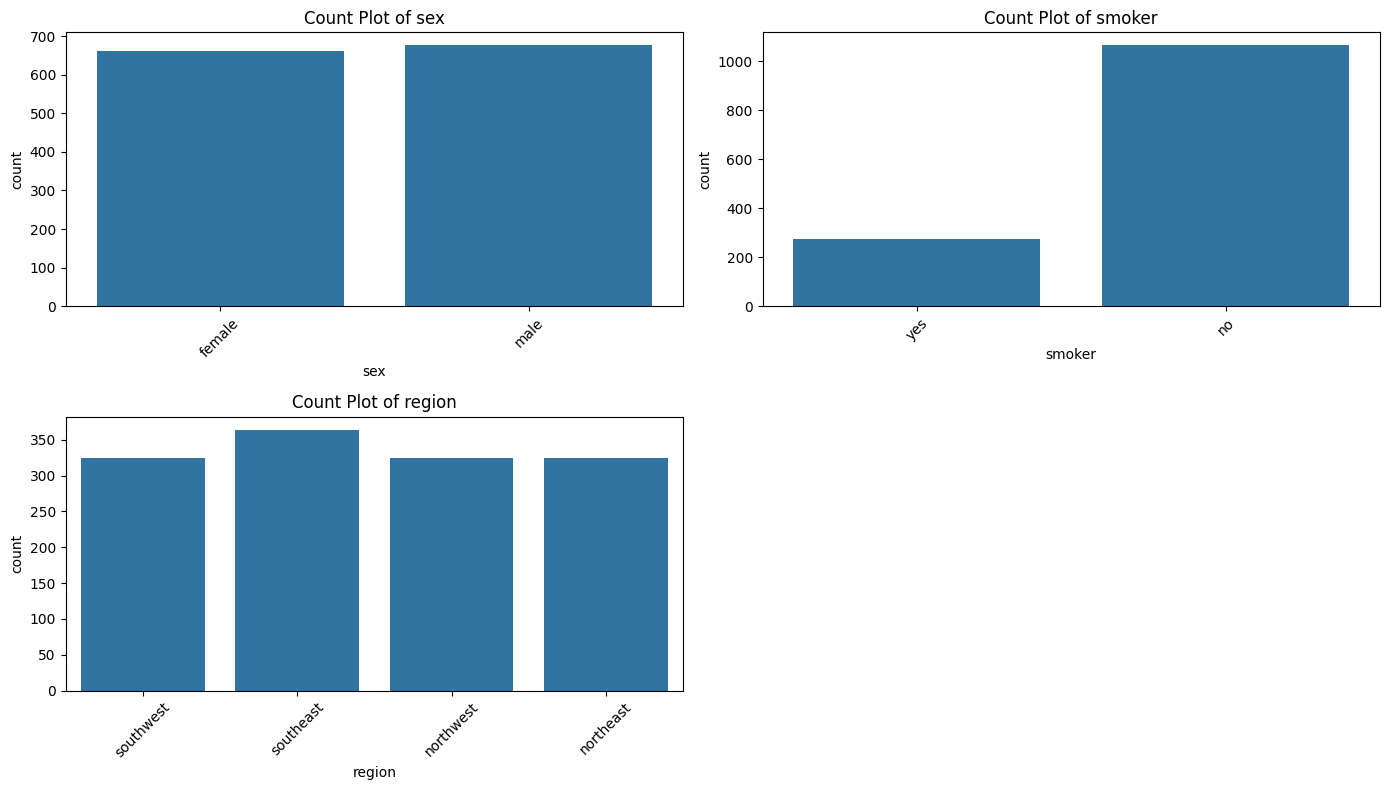

In [183]:
# creating countplots for all categorical variables

# Select categorical columns
cat_cols = df.select_dtypes(include=["object", "category"]).columns

# Determine grid size (2 columns)
n = len(cat_cols)
rows = math.ceil(n / 2)

fig, axes = plt.subplots(rows, 2, figsize=(14, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"Count Plot of {col}")
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### 2.2 Handle missing values and clean data

In [184]:
# create dummy variables for categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

In [185]:
df_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


### 2.3 Feature selection and engineering

In [186]:
# Create log-transformed versions of BMI and charges
df_encoded["bmi_log"] = np.log1p(df_encoded["bmi"])
df_encoded["charges_log"] = np.log1p(df_encoded["charges"])

# Optional: inspect the transformation
df_encoded[["bmi", "bmi_log", "charges", "charges_log"]].head()

,bmi,bmi_log,charges,charges_log
0,27.900,3.363842,16884.92400,9.734236
1,33.770,3.548755,1725.55230,7.453882
2,33.000,3.526361,4449.46200,8.400763
3,22.705,3.165686,21984.47061,9.998137
4,28.880,3.397189,3866.85520,8.260455


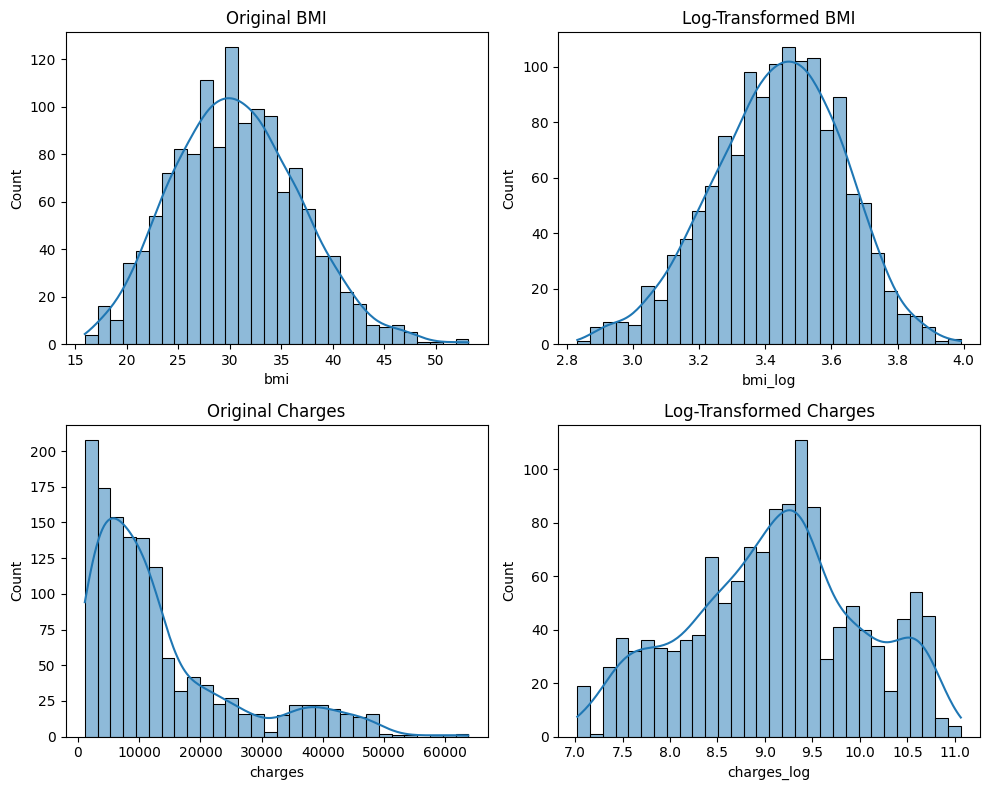

In [187]:
# Visualize transformations and compare with original
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(df_encoded["bmi"], bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title("Original BMI")

sns.histplot(df_encoded["bmi_log"], bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title("Log-Transformed BMI")

sns.histplot(df_encoded["charges"], bins=30, kde=True, ax=axes[1,0])
axes[1,0].set_title("Original Charges")

sns.histplot(df_encoded["charges_log"], bins=30, kde=True, ax=axes[1,1])
axes[1,1].set_title("Log-Transformed Charges")

plt.tight_layout()
plt.show()


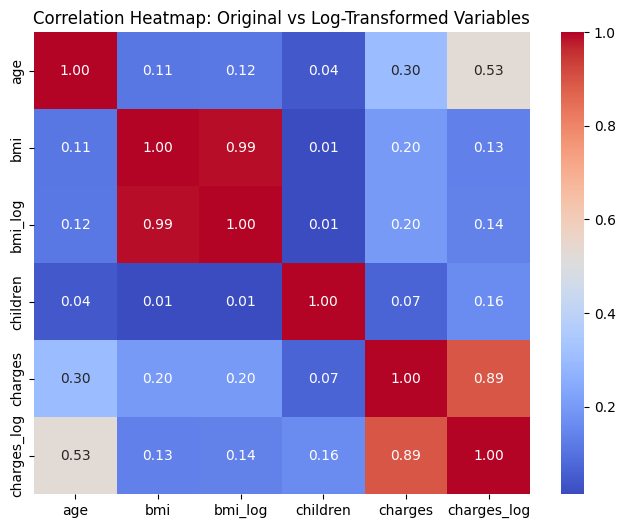

In [188]:
# Select only original + log-transformed + numeric variables
numeric_cols = ["age", "bmi", "bmi_log", "children", "charges", "charges_log"]

# Compute correlation matrix
corr = df_encoded[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Original vs Log-Transformed Variables")
plt.show()

In [189]:
# Interaction features
df_encoded["bmi_smoker_interaction"] = df_encoded["bmi"] * df_encoded["smoker_yes"]
df_encoded["age_smoker_interaction"] = df_encoded["age"] * df_encoded["smoker_yes"]
df_encoded["age_bmi_interaction"] = df_encoded["age"] * df_encoded["bmi"]

# Optional: BMI category
df_encoded["bmi_category"] = pd.cut(
    df_encoded["bmi"],
    bins=[0, 18.5, 25, 30, 35, 100],
    labels=["underweight", "normal", "overweight", "obese", "severely_obese"]
)


In [190]:
df_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_log,charges_log,bmi_smoker_interaction,age_smoker_interaction,age_bmi_interaction,bmi_category
0,19,27.900,0,16884.92400,False,True,False,False,True,3.363842,9.734236,27.9,19,530.100,overweight
1,18,33.770,1,1725.55230,True,False,False,True,False,3.548755,7.453882,0.0,0,607.860,obese
2,28,33.000,3,4449.46200,True,False,False,True,False,3.526361,8.400763,0.0,0,924.000,obese
3,33,22.705,0,21984.47061,True,False,True,False,False,3.165686,9.998137,0.0,0,749.265,normal
4,32,28.880,0,3866.85520,True,False,True,False,False,3.397189,8.260455,0.0,0,924.160,overweight


In [191]:
df_encoded = pd.get_dummies(df_encoded, drop_first=True)

In [192]:
df_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_log,charges_log,bmi_smoker_interaction,age_smoker_interaction,age_bmi_interaction,bmi_category_normal,bmi_category_overweight,bmi_category_obese,bmi_category_severely_obese
0,19,27.900,0,16884.92400,False,True,False,False,True,3.363842,9.734236,27.9,19,530.100,False,True,False,False
1,18,33.770,1,1725.55230,True,False,False,True,False,3.548755,7.453882,0.0,0,607.860,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False,3.526361,8.400763,0.0,0,924.000,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False,3.165686,9.998137,0.0,0,749.265,True,False,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False,3.397189,8.260455,0.0,0,924.160,False,True,False,False


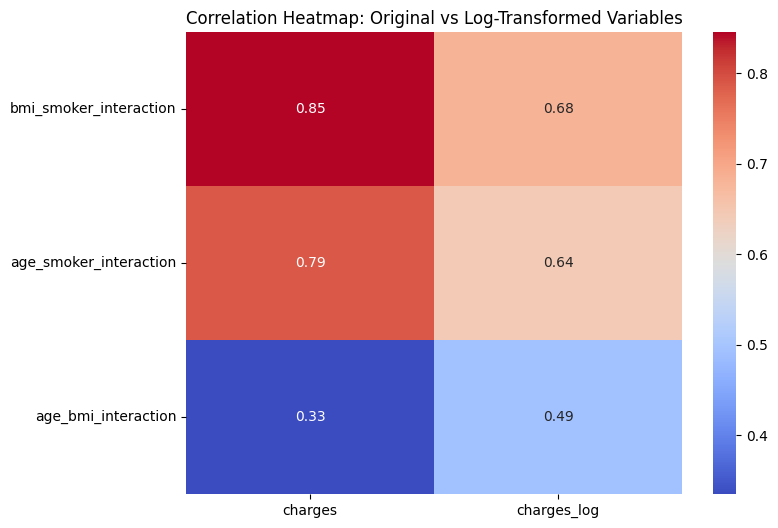

In [193]:
corr = df_encoded.corr()
corr = corr.loc[["bmi_smoker_interaction", "age_smoker_interaction", "age_bmi_interaction"], ["charges", "charges_log"]]

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Original vs Log-Transformed Variables")
plt.show()


### Reflection 2 
What patterns or anomalies do you see? Do any features stand out? What preprocessing steps were necessary to clean and improve the data? Did you create or modify any features to improve performance?

<b>Transformations</b>  
- Log transformations for bmi and charges address skewed distributions.  
- Creation of bmi categories can help the model make connections between different ranges of bmi and how they impact charges.

<b>Why make these transformations?</b>  
- Log of charges has a higher correlation with age than regular charges, increasing the prediction value of age.
- Log of bmi reduces skew and increases linearity between bmi and charges, which will improve model fit.

<b>Features created</b>  
- bmi_smoker_interaction (bmi * smoker_yes)  
- age_smoker_interaction (age * smoker_yes)
- age_bmi_interaction (age * bmi)

<b>Why add these features?</b>    
- All sets of these variables increase health risks together, which increases charges. 
- There is a high correlation between these new features and charges, so they should be helpful for prediction.  

Interestingly, bmi_smoker_interaction and age_smoker_interaction have lower correlations with the log of charges, meaning it may be best to not use charges_log for training our model.



## Section 3. Feature Selection and Justification

### 3.1 Choose features and target

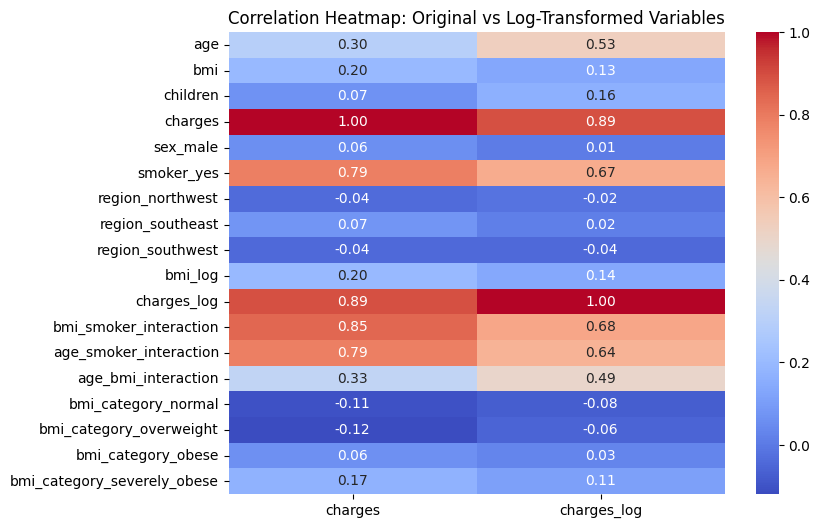

In [194]:
corr = df_encoded.corr()
filtered_corr = corr.loc[:,["charges", "charges_log"]]

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(filtered_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Original vs Log-Transformed Variables")
plt.show()

In [195]:
features = ["age", "bmi_log", "smoker_yes", "bmi_smoker_interaction", "age_smoker_interaction", "age_bmi_interaction"]
target = ["charges"]

### 3.2 Define X and y

In [196]:
X = df_encoded[features]
y = df_encoded[target]

### Reflection 3
<b>Why did you choose these features? How might they impact predictions or accuracy?</b>  

- These features had the highest correlations with charges.  
- The variety of different data should hopefully improve prediction accuracy. Three types of data are used: age, bmi, and smoker status.


## Section 4. Train a Model (Linear Regression)

### 4.1 Split the data into training and test sets using train_test_split (or StratifiedShuffleSplit if class imbalance is an issue).

In [197]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

We could stratify for y to maintain balanced splits using quantile bins. For now, I will not stratify.

### 4.2 Train model using Scikit-Learn model.fit() method

In [198]:
# Create the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

### 4.3 Evalulate performance

In [199]:
# Regression: R^2, MAE, RMSE

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R^2:  {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

R^2:  0.8589
MAE:  2859.6271
RMSE: 4680.4755


### Reflection 4  
<b>How well did the model perform? Any surprises in the results?</b>  

I am happy with the model's R^2 score of 0.8589. Because of the high linear correlation between some of my features and charges, I was hoping for a model that performs better. A few ideas for increased performance could be:
- create a feature that combines age, smoking, and bmi to see if it has higher correlation with charges
- examining cases where predictions were wrong by a large margin and seeing if the model is not performing well under certain combinations of features
- implementing pipelines to scale data

## Section 5. Improve the Model or Try Alternates (Implement Pipelines)

### 5.1 Implement Pipeline 1: Imputer → StandardScaler → Linear Regression.

In [200]:
pipeline1 = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

pipeline1.fit(X_train, y_train)

y_pred = pipeline1.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Pipeline 1 Results:")
print(f"R^2:  {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


Pipeline 1 Results:
R^2:  0.8589
MAE:  2859.6271
RMSE: 4680.4755


### 5.2 Implement Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression.

In [201]:
pipeline2 = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

pipeline2.fit(X_train, y_train)

y_pred2 = pipeline2.predict(X_test)

r2_2 = r2_score(y_test, y_pred2)
mae_2 = mean_absolute_error(y_test, y_pred2)
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred2))

print("Pipeline 2 Results:")
print(f"R^2:  {r2_2:.4f}")
print(f"MAE:  {mae_2:.4f}")
print(f"RMSE: {rmse_2:.4f}")

Pipeline 2 Results:
R^2:  0.8355
MAE:  2706.1911
RMSE: 5053.7009


### 5.3 Implement Pipeline 3: Imputer → StandardScaler → Lasso


Finding the best alpha value for lasso regression

In [202]:

alphas = np.logspace(-4, 5, 200)   # 0.0001 → 100,000

r2_scores = []
mae_scores = []
rmse_scores = []

for a in alphas:
    # Build a fresh pipeline for each alpha
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("lasso", Lasso(alpha=a, max_iter=5000))
    ])

    # Fit full pipeline
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluation metrics
    r2_scores.append(r2_score(y_test, y_pred))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

best_idx = np.argmax(r2_scores)
best_alpha = alphas[best_idx]

r2_3 = r2_scores[best_idx]
mae_3 = mae_scores[best_idx]
rmse_3 = rmse_scores[best_idx]

print("Best alpha:", best_alpha)
print("Best R^2:", r2_3)
print("Best MAE:", mae_3)
print("Best RMSE:", rmse_3)

Best alpha: 29.673024081888727
Best R^2: 0.8595907753549865
Best MAE: 2884.455896293278
Best RMSE: 4668.870743111423


### Reflection 5  
<b>Which models performed better? How does scaling impact results?</b>



In [203]:
results = [
    {
    "model": "Pipeline 1",
    "R^2": r2,
    "MAE": mae,
    "RMSE": rmse,
    },
    {
    "model": "Pipeline 2",
    "R^2": r2_2,
    "MAE": mae_2,
    "RMSE": rmse_2,
    },
    {
    "model": "Pipeline 3",
    "R^2": r2_3,
    "MAE": mae_3,
    "RMSE": rmse_3,
    }
]

df_results = pd.DataFrame(results)
df_results

,model,R^2,MAE,RMSE
0,Pipeline 1,0.858892,2859.627136,4680.475459
1,Pipeline 2,0.835490,2706.191140,5053.700904
2,Pipeline 3,0.859591,2884.455896,4668.870743


## Section 6. Final Thoughts & Insights

### 6.1 Summarize findings.

### 6.2 Discuss challenges faced.

### 6.3 If you had more time, what would you try next?

### Reflection 6
<b>What did you learn from this project?</b>

